In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np

In [5]:
kge=[]
for i in range(626):
    file=f'/glade/campaign/cgd/tss/people/guoqiang/CTSM_CAMELS_proj/Calib_HH_MOASMO/level1_{i}_MOASMOcalib/param_sets/surrogate_model_for_iter0_CV_kge.csv'
    if os.path.isfile(file):
        df=pd.read_csv(file)
        kge.append(df.loc[df['Fold']=='Mean']['KGE_Score'].values)

In [16]:
kge = np.array(kge)
print('basin num:', len(kge))
print('mean kge:', np.nanmean(kge))
print('median kge:', np.nanmedian(kge))

basin num: 625
mean kge: 0.8008121256540204
median kge: 0.8455921383879655


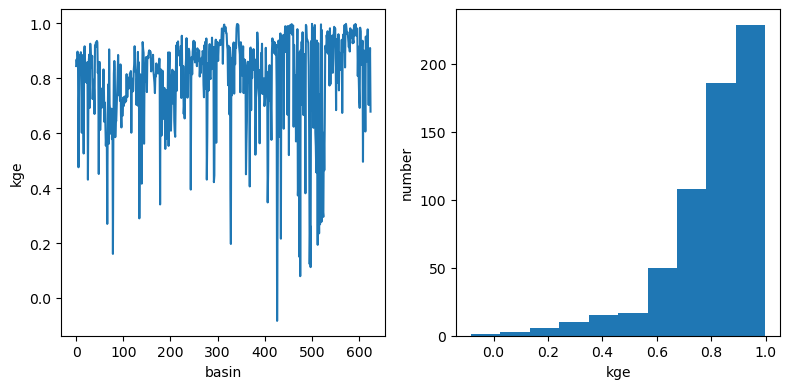

In [17]:

fig = plt.figure(figsize=[8, 4])

fig.add_subplot(1,2,1)
plt.plot(kge)
plt.xlabel('basin')
plt.ylabel('kge')

fig.add_subplot(1,2,2)
plt.hist(kge)
plt.xlabel('kge')
plt.ylabel('number')

plt.tight_layout()
plt.show()
